In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

from sklearn.model_selection import train_test_split

FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# 1 = Equations 
# 0 = Not Equations

In [33]:
filenames = os.listdir("../input_data/equation_data")
categories = []
for filename in filenames:
    if "image" in filename:
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({'filename': filenames, 'category': categories})

In [34]:
model = Sequential()

model.add(
    Conv2D(
        32, (3, 3),
        activation='relu',
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [35]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [36]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input_data/equation_data", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 815 images belonging to 2 classes.


In [40]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../input_data/equation_data/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size)

Found 203 images belonging to 2 classes.


In [42]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input_data/equation_data/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary'
)

Found 1 images belonging to 1 classes.


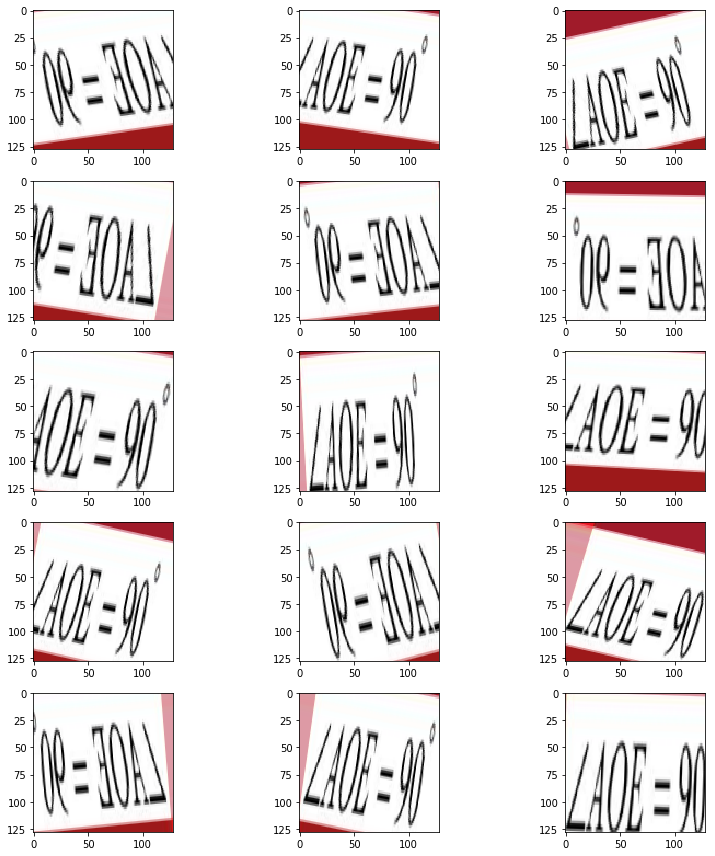

In [43]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [44]:
epochs=3 if FAST_RUN else 3
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
54/54 [==============================] - 84s 2s/step - loss: 0.6672 - acc: 0.7309 - val_loss: 1.2674 - val_acc: 0.4051
Epoch 2/3
54/54 [==============================] - 81s 2s/step - loss: 0.2007 - acc: 0.9395 - val_loss: 0.9562 - val_acc: 0.6968
Epoch 3/3
54/54 [==============================] - 85s 2s/step - loss: 0.0756 - acc: 0.9802 - val_loss: 0.0862 - val_acc: 0.9947


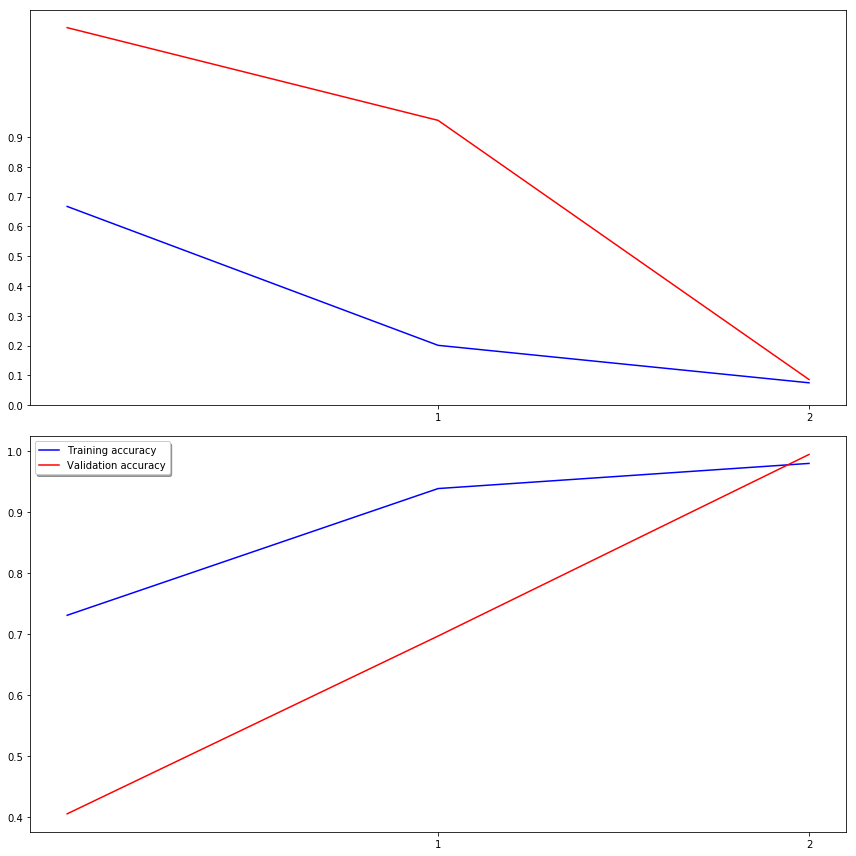

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [109]:
test_filenames = os.listdir("../input_data/equation_test_data")
test_df = pd.DataFrame({'filename': test_filenames})
nb_samples = test_df.shape[0]

In [110]:
test_gen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "../input_data/equation_test_data/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False)

Found 36 images.


In [111]:
predict = model.predict_generator(
    test_generator, steps=np.ceil(nb_samples / batch_size))

In [112]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

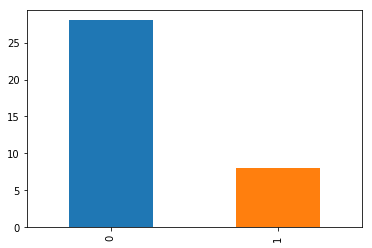

In [113]:
test_df['category'].value_counts().plot.bar()

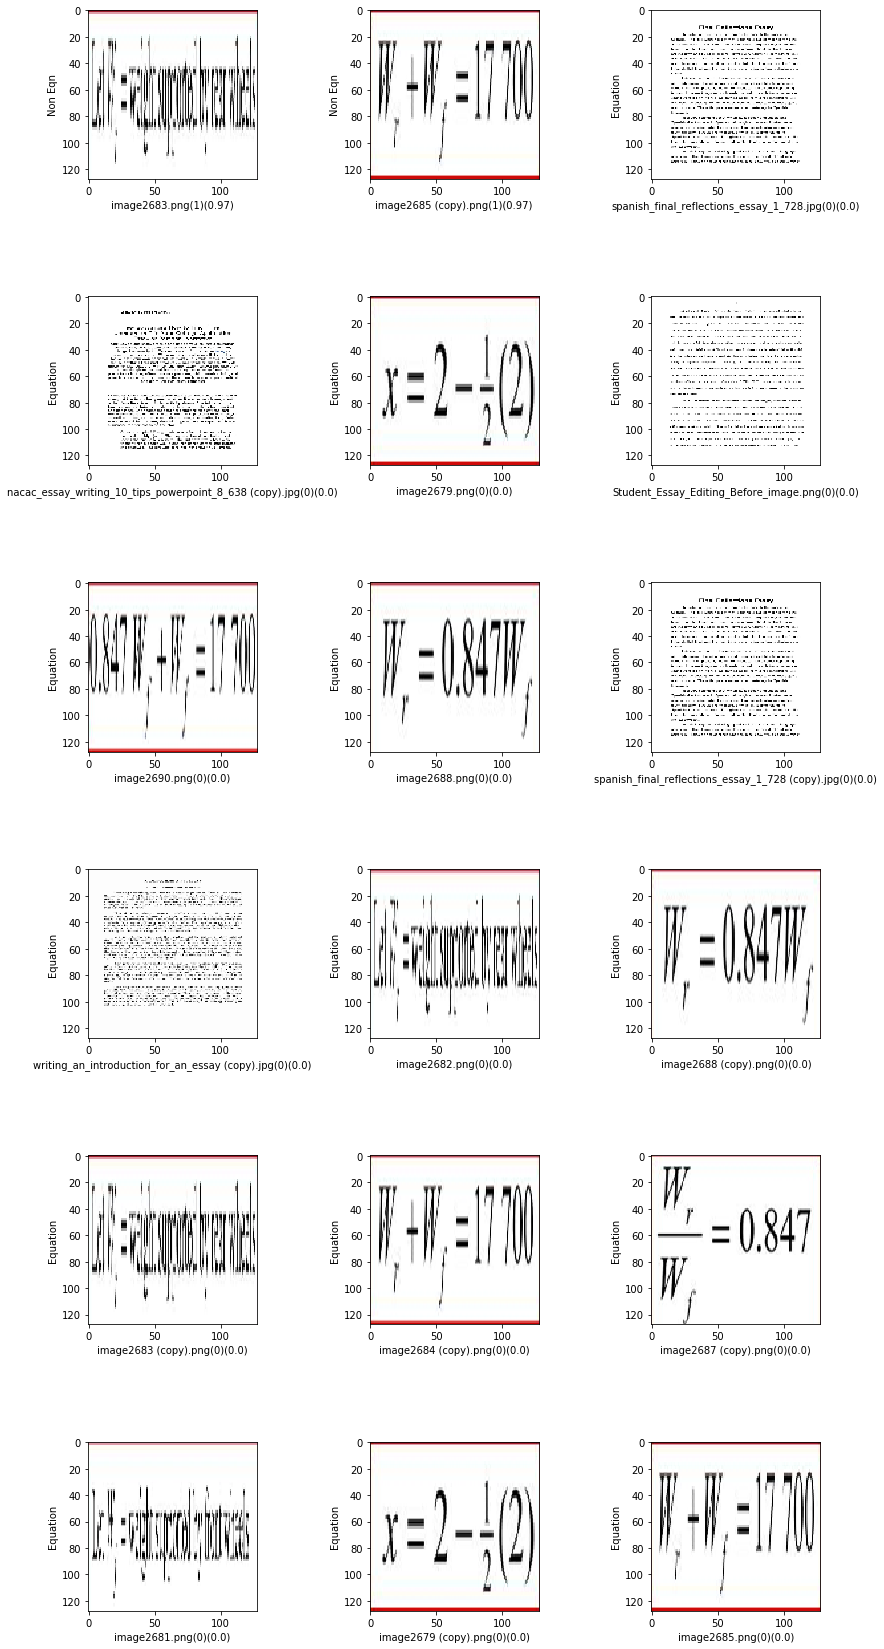

In [114]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("../input_data/equation_test_data/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
    plt.ylabel("Equation" if category == 0 else "Non Eqn")
plt.tight_layout()
plt.show()